# Modeling
I also want to guess the valoration of a movie from the rest of information.

In [26]:
import pandas as pd
import numpy as np

In [27]:
data = pd.read_csv('data\imdb_processed.csv')

### 1 - Selection
Some of the columns are not needed for modelling, but I need them for visualization.

In [28]:
non_model_info = data[['tconst', 'primaryTitle', 'startYear']]
non_model_info.head(1)

,tconst,primaryTitle,startYear
0,tt0023526,Stranger in Town,1932


In [29]:
data = data.drop(['tconst', 'primaryTitle', 'startYear'], axis=1)
data.head(1)

,isAdult,runtimeMinutes,rating,genres,mpaa,description,votes,year_process
0,0,65,6.1,['drama'],PG,"[""Ulysses Crickle owns a small town grocery st...",115.0,1932


I also want to keep the target separated:

In [30]:
target = data['rating']
data = data.drop('rating', axis=1)


If I tokenize the ``genres`` column, I can use it for the models.

In [31]:
from nltk.tokenize import word_tokenize

def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    s = word_tokenize(s)

    return s

In [32]:
# data['genres_token'] = data.genres.apply(word_tokenize)

In [33]:
# token_list = data['genres_token'].tolist()

In [34]:
import re

In [35]:
# word_list = []
# regx  = '''[\[\]\"\']'''


# for token in token_list:
#     # word_list = word_list + list(token_list[i])
#     token = re.sub(regx,'',token)
#     list = token.split(',')
#     word_list = word_list + list

In [36]:
from nltk.probability import FreqDist


def frequency(column, amount = 100):
    '''
    Args:
        column: Pandas series of tokenized lists (in the form of a df column)
        amount: the amount of mos common words we want

    Returns:
        A list of tuples of size equals to the amount with the word, and the number of times it appears in the bag of words
    '''


    token_list = column.tolist()

    word_list = []
    regx  = '''[\[\]\"\']''' # I need to clean the lists

    for token in token_list:
        token = re.sub(regx,'',token)
        list = token.split(',')
        word_list = word_list + list

    fd = FreqDist(word_list)
    most_common = fd.most_common(amount)
    return most_common, word_list

In [37]:
def find_features(row):
    words = row['text_processed']
    features = {}
    for w in word_list:
        features[w] = (w in words)

        

    return (features, row['target'])

In [38]:
data.head()

,isAdult,runtimeMinutes,genres,mpaa,description,votes,year_process
0,0,65,['drama'],PG,"[""Ulysses Crickle owns a small town grocery st...",115.0,1932
1,0,76,"['comedy', 'drama']",Not Rated,['_Strangers in Love_ (qv) is a 1932 American ...,144.0,1932
2,0,70,"['comedy', 'mystery']",Approved,['Bodies start mysteriously disappearing from ...,218.0,1932
3,0,59,"['drama', 'romance']",Approved,"[""A married architect, stuck in a loveless mar...",356.0,1932
4,0,99,['comedy'],Not Rated,['Whoever of a group of eager bicycle racers f...,14.0,1932


### 2 - Train/Test split

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In order to improve accuracy in the models, I want to normalize the numerical data, and encode the categorical data.
Also, I have two columns that I want to treat differently.

In [41]:
# numerical = data.select_dtypes(np.number)
# text = data[['genres', 'description']]
# categorical = data['mpaa']

X_train_numerical = X_train.select_dtypes(np.number)
X_train_categorical = pd.DataFrame()
X_train_categorical['mpaa'] = X_train['mpaa'].copy()

X_test_numerical = X_test.select_dtypes(np.number)
X_test_categorical = pd.DataFrame()
X_test_categorical['mpaa'] = X_test['mpaa'].copy()

### 3 - Numerical Scaling
The numerical data has very different ranges, so I will scale them.

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
transformer = MinMaxScaler().fit(X_train_numerical)
X_train_num_tran = transformer.transform(X_train_numerical)

X_train_num_tran = pd.DataFrame(X_train_num_tran, columns=X_train_numerical.columns)
# X_train_num_tran.shape

X_test_num_tran = transformer.transform(X_test_numerical)

X_test_num_tran = pd.DataFrame(X_test_num_tran, columns=X_test_numerical.columns)


### 4 - Categorical Encoding
I need to transform the categories of the age ratings in the ``mpaa`` column to be numbers

In [44]:
X_test['mpaa'].value_counts()

Not Rated    4919
Approved     1932
R             393
PG            321
G             134
PG-13         134
NC-17         125
Name: mpaa, dtype: int64

In [45]:
dict = {'Not Rated': 0, 'Approved': 1, 'G': 2, 'PG': 3, 'PG-13': 4, 'R': 5, 'NC-17': 6}

X_train_cat_label = X_train_categorical.replace({"mpaa": dict}).reset_index(drop=True)

X_test_cat_label = X_test_categorical.replace({"mpaa": dict}).reset_index(drop=True)

### 5 - Putting everything back together

In [46]:
X_train_tran = pd.concat([X_train_num_tran, X_train_cat_label], axis=1)
# X_train_tran

In [47]:
X_test_tran = pd.concat([X_test_num_tran, X_test_cat_label], axis=1)
# X_test_tran

### 6 - Check correlations

In [48]:
import seaborn as sns

In [50]:
corr = X_train_tran.corr()

<AxesSubplot:>

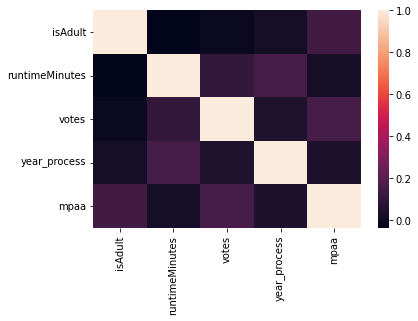

In [51]:
sns.heatmap(corr)

There are no correlations, but that might indicate that 

### 7 - Models

In [57]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

In [59]:
lm = linear_model.LinearRegression()
lm.fit(X_train_tran,y_train)

LinearRegression()

In [60]:
def metrics(X, y):
    #Finds and prints the metrics of the algorithm
    predictions = lm.predict(X)
    r2 = r2_score(y, predictions)
    print('R2:', r2)
    mse = np.sqrt(mean_squared_error(y,predictions))
    print('MSE:', mse)
    rmse = math.sqrt(mse)
    print('RMSE:', rmse)
    mae = mean_absolute_error(y, predictions)
    print('MAE:', mae)

In [62]:
metrics(X_test_tran,y_test)

R2: 0.04580805814119282
MSE: 1.083247390233663
RMSE: 1.0407917131845656
MAE: 0.823900065134208


This is a pretty bad R2 score...
That would make some sense, as the reception of the movie does not depend at all on the metrics I had access to. That is why even high budget movies can flop easily.

In [63]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr')
classification.fit(X_train_tran, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
predictions = classification.predict(X_test_tran)
predictions
classification.score(X_test_tran, y_test)